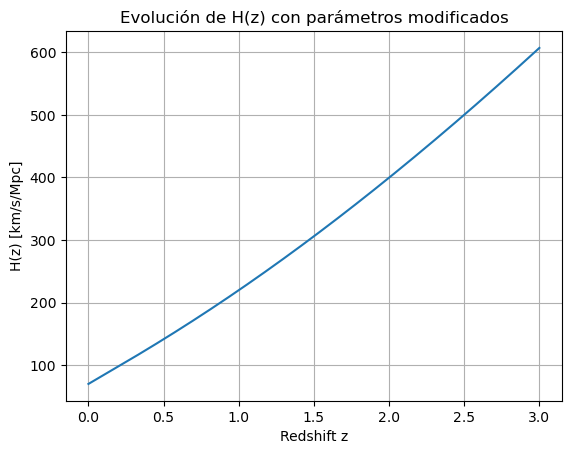

In [1]:
import numpy as np
from dataclasses import dataclass
from typing import Iterable, Tuple
from scipy.optimize import brentq

@dataclass
class Params:
    H0: float                 # p.ej. km/s/Mpc
    Omega_m: float
    alpha_delta: float
    delta: float
    alpha_epsilon: float
    epsilon: float
    C: float                  # mismas unidades que H0^2
    enforce_closure: bool = True  # True => impone H(0)=H0 ajustando C

def _coeffs_dimensionless(par: Params) -> Tuple[float, float, float, float, float]:
    # a_δ = α_δ H0^{2(1-δ)}, a_ε = α_ε H0^{2(1-ε)}, c = C/H0^2
    a_delta = par.alpha_delta * par.H0**(2.0*(1.0 - par.delta))
    a_eps   = par.alpha_epsilon * par.H0**(2.0*(1.0 - par.epsilon))
    c       = par.C / (par.H0**2)
    if par.enforce_closure:
        c = a_delta + a_eps - par.Omega_m  # garantiza H(0)=H0
    p_delta = 4.0 - 2.0*par.delta
    p_eps   = 4.0 - 2.0*par.epsilon
    return a_delta, a_eps, c, p_delta, p_eps

def _rhs(z, Omega_m, c):
    return Omega_m*(1.0 + z)**3 + c

def _f_x(x, z, Omega_m, a_delta, p_delta, a_eps, p_eps, c):
    lhs = 0.0
    if a_delta != 0.0: lhs += a_delta * (x**p_delta)
    if a_eps   != 0.0: lhs += a_eps   * (x**p_eps)
    return lhs - _rhs(z, Omega_m, c)   # buscamos f=0

def _analytic_upper_bound(z, Omega_m, c, a_delta, p_delta, a_eps, p_eps):
    """Cota superior rápida si a_delta,a_eps >= 0: usar el término 'más barato' (menor exponente/coef)."""
    R = _rhs(z, Omega_m, c)
    candidates = []
    if a_delta > 0 and p_delta > 0:
        candidates.append( (R / a_delta)**(1.0/p_delta) )
    if a_eps > 0 and p_eps > 0:
        candidates.append( (R / a_eps)**(1.0/p_eps) )
    if candidates:
        return max(candidates) * 1.5  # margen
    return None

def solve_H_of_z(zs: Iterable[float], par: Params,
                 x_lo_floor: float = 0.0,
                 expand_factor: float = 2.0,
                 max_expand: int = 40):
    """
    Devuelve H(z) (mismas unidades que H0) para z (array o escalar).
    Usa continuación en z y bracketing seguro.
    """
    zs = np.atleast_1d(zs).astype(float)
    a_delta, a_eps, c, p_delta, p_eps = _coeffs_dimensionless(par)

    # chequeos suaves
    if p_delta <= 0 or p_eps <= 0:
        # con tu info (δ,ε>0 ~1) esto no debería ocurrir
        raise ValueError("Se requieren p_delta>0 y p_eps>0 (i.e., δ,ε<2).")

    Hvals = np.empty_like(zs, dtype=float)

    # ordenar por z creciente para que la continuación sea estable
    order = np.argsort(zs)
    zs_sorted = zs[order]

    # valor inicial (z mínimo): si a_delta+a_eps>0, usar x* ~ sqrt(R/(aδ+aε))
    denom = (a_delta + a_eps)
    def x_guess(z):
        R = _rhs(z, par.Omega_m, c)
        if denom > 0 and R >= 0:
            return np.sqrt(max(R, 0.0) / denom)
        # fallback
        return 1.0 + 0.5*z

    x_prev = x_guess(zs_sorted[0])

    for z in zs_sorted:
        f = lambda x: _f_x(x, z, par.Omega_m, a_delta, p_delta, a_eps, p_eps, c)

        # Bracket inicial alrededor de la predicción previa
        # Lo ideal es [x_prev/β, x_prev*β] con β moderado, respetando x>=0
        beta = 2.0
        lo = max(x_lo_floor, x_prev / beta)
        hi = x_prev * beta

        # Mejorar 'hi' con cota analítica si aplica
        hi_bound = _analytic_upper_bound(z, par.Omega_m, c, a_delta, p_delta, a_eps, p_eps)
        if hi_bound is not None:
            hi = max(hi, hi_bound)

        flo, fhi = f(lo), f(hi)
        n = 0
        # expandir hasta cambio de signo
        while np.sign(flo) == np.sign(fhi) and n < max_expand:
            # como f crece con x si a's >=0, subir hi es efectivo
            hi = max(hi * expand_factor, hi + 1.0)
            fhi = f(hi)
            if flo > 0:  # si ya estamos por arriba en lo, bajar lo
                lo = max(x_lo_floor, lo / expand_factor)
                flo = f(lo)
            n += 1

        if np.sign(flo) == np.sign(fhi):
            raise RuntimeError(
                f"No se logró encerrar la raíz (z={z:.4g}). "
                f"f(lo)={flo:.3e}, f(hi)={fhi:.3e}, lo={lo:.3e}, hi={hi:.3e}. "
                "Verificá signos de α y consistencia de parámetros."
            )

        x_root = brentq(f, lo, hi, xtol=1e-12, rtol=1e-10, maxiter=200)
        Hvals[zs == z] = x_root * par.H0
        x_prev = x_root  # continuidad

    # reordenar a la forma original
    H_out = np.empty_like(zs)
    H_out[order] = Hvals
    return H_out if H_out.size > 1 else H_out.item()

# ----------------- ejemplo rápido -----------------
if __name__ == "__main__":
    pars = Params(
        H0 = 70.0,
        Omega_m = 0.3,
        alpha_delta = 0.12,
        delta = 0.95,         # cerca de 1  => p_delta ~ 2.1
        alpha_epsilon = 0.05,
        epsilon = 1.05,       # cerca de 1  => p_eps   ~ 1.9
        C = 0.0,
        enforce_closure = True
    )
    z = np.linspace(0.0, 3.0, 200)
    Hz = solve_H_of_z(z, pars)
    # Hz es H(z) en km/s/Mpc


    # Ahora Hz es un array con H(z) en km/s/Mpc
    import matplotlib.pyplot as plt
    plt.plot(z, Hz)
    plt.xlabel("Redshift z")
    plt.ylabel("H(z) [km/s/Mpc]")
    plt.title("Evolución de H(z) con parámetros modificados")
    plt.grid()
    plt.show()

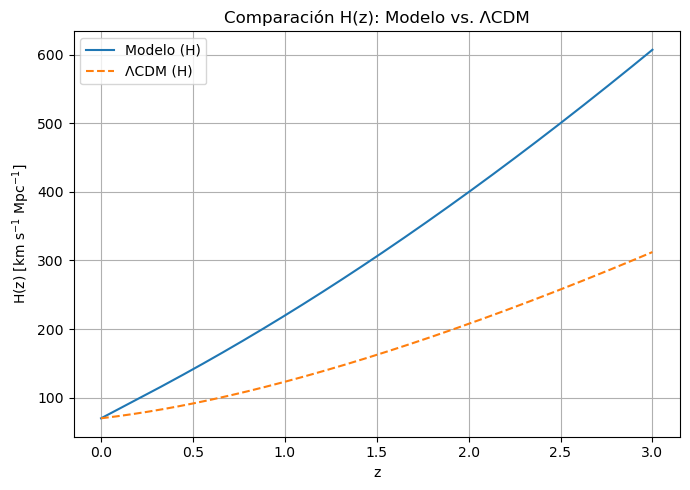

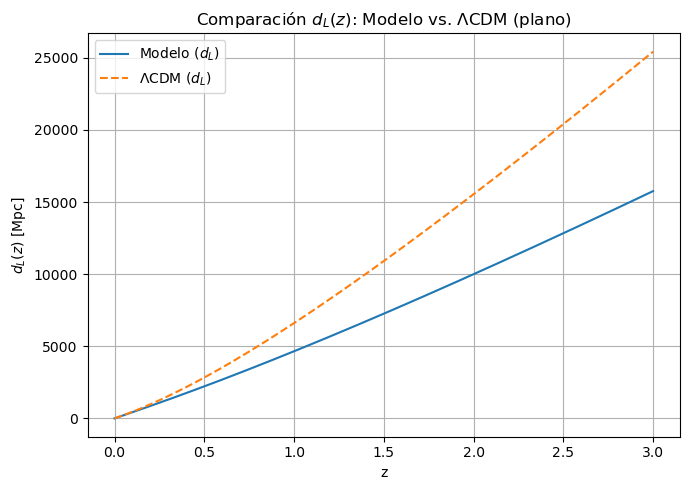

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Gráficos de H(z) y d_L(z): Modelo (α_δ, δ, α_ε, ε) vs. ΛCDM (plano).
- Resuelve H(z) con Brent y continuidad en z (warm start)
- Impone H(0)=H0 si enforce_closure=True (ajusta C automáticamente)

Requisitos: numpy, matplotlib (sin SciPy; trae un brentq simple incluido)
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

# ----------------------- Parámetros del modelo -----------------------
H0 = 70.0           # km/s/Mpc
Omega_m = 0.3
alpha_delta = 0.12
delta = 0.95
alpha_epsilon = 0.05
epsilon = 1.05
C = 0.0             # ignorado si enforce_closure=True
enforce_closure = True

#1)
#H0 = 70.0           # km/s/Mpc
#Omega_m = 0.3
#alpha_delta = 1
#delta = 1
#alpha_epsilon = 0.
#epsilon = 1.05
#C = 0.0             # ignorado si enforce_closure=True
#enforce_closure = True

#2)
#H0 = 70.0           # km/s/Mpc
#Omega_m = 0.3
#alpha_delta = 0.
#delta = 1.05
#alpha_epsilon = 1
#epsilon = 1
#C = 0.0             # ignorado si enforce_closure=True
#enforce_closure = True

#3)
#H0 = 70.0           # km/s/Mpc
#Omega_m = 0.3
#alpha_delta = 0.5
#delta = 1
#alpha_epsilon = 0.5
#epsilon = 1
#C = 0.0             # ignorado si enforce_closure=True
#enforce_closure = True

# Rango de z para graficar
z_min, z_max, nz = 0.0, 3.0, 250
z = np.linspace(z_min, z_max, nz)

# ----------------------- Núcleo del modelo -----------------------

def coeffs_dimensionless(H0, Omega_m, alpha_delta, delta, alpha_epsilon, epsilon, C, enforce_closure=True):
    """Devuelve a_δ, a_ε, c, p_δ, p_ε en unidades adimensionales."""
    a_delta = alpha_delta * H0**(2.0*(1.0 - delta))
    a_eps   = alpha_epsilon * H0**(2.0*(1.0 - epsilon))
    c       = C / (H0**2)
    if enforce_closure:
        # c = a_delta + a_eps - Omega_m  garantiza H(0)=H0
        c = a_delta + a_eps - Omega_m
    p_delta = 4.0 - 2.0*delta
    p_eps   = 4.0 - 2.0*epsilon
    if p_delta <= 0 or p_eps <= 0:
        raise ValueError("Se requieren p_delta>0 y p_eps>0 (i.e., δ,ε<2).")
    return a_delta, a_eps, c, p_delta, p_eps

def rhs_target(z, Omega_m, c):
    return Omega_m*(1.0 + z)**3 + c

def f_x(x, z, Omega_m, a_delta, p_delta, a_eps, p_eps, c):
    lhs = 0.0
    if a_delta != 0.0: lhs += a_delta * x**p_delta
    if a_eps   != 0.0: lhs += a_eps   * x**p_eps
    return lhs - rhs_target(z, Omega_m, c)   # buscamos f=0

def analytic_upper_bound(z, Omega_m, c, a_delta, p_delta, a_eps, p_eps):
    """Cota superior rápida si a_delta,a_eps >= 0."""
    R = rhs_target(z, Omega_m, c)
    candidates = []
    if a_delta > 0 and p_delta > 0:
        candidates.append( (R / a_delta)**(1.0/p_delta) )
    if a_eps > 0 and p_eps > 0:
        candidates.append( (R / a_eps)**(1.0/p_eps) )
    if candidates:
        return max(candidates) * 1.5  # margen
    return None

def solve_H_of_z(zs, H0, Omega_m, alpha_delta, delta, alpha_epsilon, epsilon, C, enforce_closure=True):
    """Devuelve H(z) en mismas unidades que H0 para un array/scalar z."""
    zs = np.atleast_1d(zs).astype(float)
    a_delta, a_eps, c, p_delta, p_eps = coeffs_dimensionless(
        H0, Omega_m, alpha_delta, delta, alpha_epsilon, epsilon, C, enforce_closure
    )
    Hvals = np.empty_like(zs, dtype=float)

    # Ordenar para usar continuidad (warm start)
    order = np.argsort(zs)
    zs_sorted = zs[order]

    denom = (a_delta + a_eps)
    def x_guess(z):
        R = rhs_target(z, Omega_m, c)
        if denom > 0 and R >= 0:
            return np.sqrt(max(R, 0.0) / denom)
        return 1.0 + 0.5*z

    x_prev = x_guess(zs_sorted[0])

    for zloc in zs_sorted:
        f_local = lambda x: f_x(x, zloc, Omega_m, a_delta, p_delta, a_eps, p_eps, c)

        beta = 2.0
        lo = max(0.0, x_prev / beta)
        hi = x_prev * beta

        hib = analytic_upper_bound(zloc, Omega_m, c, a_delta, p_delta, a_eps, p_eps)
        if hib is not None:
            hi = max(hi, hib)

        flo, fhi = f_local(lo), f_local(hi)
        expand_factor, max_expand, n = 2.0, 40, 0
        while np.sign(flo) == np.sign(fhi) and n < max_expand:
            hi = max(hi * expand_factor, hi + 1.0)
            fhi = f_local(hi)
            if flo > 0:
                lo = lo / expand_factor
                flo = f_local(lo)
            n += 1
        if np.sign(flo) == np.sign(fhi):
            raise RuntimeError(
                f"No se pudo acotar la raíz en z={zloc:.4g} (f(lo)={flo:.3e}, f(hi)={fhi:.3e})"
            )

        x_root = brentq(f_local, lo, hi, maxiter=200)
        Hvals[zs == zloc] = x_root * H0
        x_prev = x_root

    H_out = np.empty_like(zs)
    H_out[order] = Hvals
    return H_out if H_out.size > 1 else H_out.item()

# ----------------------- ΛCDM plano y distancias -----------------------

def H_LCDM(z, H0, Omega_m):
    return H0*np.sqrt(Omega_m*(1.0+z)**3 + (1.0 - Omega_m))

def comoving_distance_from_E(z, E, H0):
    """
    χ(z) = (c/H0) ∫_0^z dz'/E(z').
    Integra por trapecios acumulado en la grilla dada.
    Devuelve χ en Mpc (si H0 en km/s/Mpc).
    """
    c_km_s = 299792.458
    chi = np.zeros_like(z)
    for i in range(1, len(z)):
        dz = z[i] - z[i-1]
        chi[i] = chi[i-1] + 0.5*dz*(1.0/E[i] + 1.0/E[i-1])
    return (c_km_s / H0) * chi

# ----------------------- Cálculo -----------------------

H_model = solve_H_of_z(z, H0, Omega_m, alpha_delta, delta, alpha_epsilon, epsilon, C, enforce_closure)
H_lcdm  = H_LCDM(z, H0, Omega_m)

E_model = H_model / H0
E_lcdm  = H_lcdm  / H0

chi_model = comoving_distance_from_E(z, E_model, H0)
chi_lcdm  = comoving_distance_from_E(z, E_lcdm,  H0)

dL_model = (1.0 + z) * chi_model
dL_lcdm  = (1.0 + z) * chi_lcdm

# ----------------------- Gráficos -----------------------

# H(z)
plt.figure(figsize=(7,5))
plt.plot(z, H_model, label="Modelo (H)")
plt.plot(z, H_lcdm, linestyle="--", label="ΛCDM (H)")
plt.xlabel("z")
plt.ylabel(r"H(z) [km s$^{-1}$ Mpc$^{-1}$]")
plt.title("Comparación H(z): Modelo vs. ΛCDM")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# d_L(z)
plt.figure(figsize=(7,5))
plt.plot(z, dL_model, label=r"Modelo ($d_L$)")
plt.plot(z, dL_lcdm, linestyle="--", label=r"ΛCDM ($d_L$)")
plt.xlabel("z")
plt.ylabel(r"$d_L(z)$ [Mpc]")
plt.title(r"Comparación $d_L(z)$: Modelo vs. ΛCDM (plano)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
